Quantum Circuit:
     ┌────────┐┌────────┐               
q_0: ┤ Ry(x0) ├┤ Ry(θ0) ├──■────────────
     ├────────┤├────────┤┌─┴─┐┌────────┐
q_1: ┤ Ry(x1) ├┤ Ry(θ1) ├┤ X ├┤ Ry(θ2) ├
     └────────┘└────────┘└───┘└────────┘


/var/folders/z3/sk2c0q6j5jqfyd9r8pm2_vrr0000gp/T/ipykernel_24970/1669300712.py:54: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)



Test Predictions:
Input: [0 1] → Predicted Label: 0
Input: [1 0] → Predicted Label: 1


/var/folders/z3/sk2c0q6j5jqfyd9r8pm2_vrr0000gp/T/ipykernel_24970/1669300712.py:96: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, marker='x', label='Test Data', edgecolors='black')


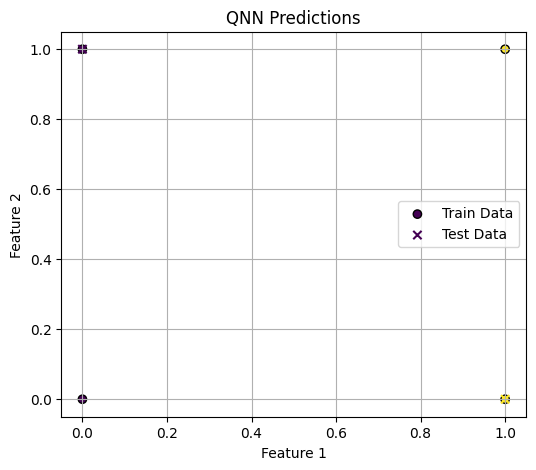

In [14]:
#-------------------------------------------------------------------------
# Complete Hybrid QNN 
# Chapter 9 in the QUANTUM COMPUTING AND QUANTUM MACHINE LEARNING BOOK
#-------------------------------------------------------------------------
# Version 1.1
# (c) 2025 Jesse Van Griensven, Roydon Fraser, and Jose Rosas 
# License:  MIT - Citation of this work required
#-------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
# Set random seed for reproducibility
algorithm_globals.random_seed = 42

# Step 1: Define the Quantum Neural Network (QNN)
def create_quantum_circuit():
    """Create a parameterized quantum circuit for the QNN."""
    circuit = QuantumCircuit(2)  # 2-qubit quantum circuit

    # Define trainable parameters (weights)
    theta_0 = Parameter('θ0')
    theta_1 = Parameter('θ1')
    theta_2 = Parameter('θ2')

    # Define input encoding parameters
    x_0 = Parameter('x0')
    x_1 = Parameter('x1')

    # Encode input data into quantum state
    circuit.ry(x_0, 0)
    circuit.ry(x_1, 1)

    # Apply trainable quantum layers
    circuit.ry(theta_0, 0)
    circuit.ry(theta_1, 1)
    circuit.cx(0, 1)  # Entanglement using a CNOT gate
    circuit.ry(theta_2, 1)

    return circuit, [x_0, x_1]

quantum_circuit, input_params = create_quantum_circuit()
print("Quantum Circuit:")
print(quantum_circuit.draw())

# Step 2: Define the QNN with the SamplerQNN Class
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

weight_params = list(set(quantum_circuit.parameters) - set(input_params))

sampler = Sampler()
qnn = SamplerQNN(
    circuit=quantum_circuit,
    input_params=input_params,
    weight_params=weight_params,
    interpret=lambda x: x,
    output_shape=4,
    sampler=sampler
)


# Step 3: Prepare a Simple Dataset for Binary Classification
X_train = np.array([[0, 1], [1, 0], [1, 1], [0, 0]])  # Input features
y_train = np.array([0, 1, 1, 0])  # Fix: Ensure correct binary labels

# Step 4: Use NeuralNetworkClassifier to Train the QNN
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=200),
    loss='squared_error',  # Fix: Ensure loss function is appropriate
    one_hot=False
)

# Train the QNN on the dataset
classifier.fit(X_train, y_train)  # Fix: Now input shape matches QNN expectation

# Step 5: Test the QNN
X_test = np.array([[0, 1], [1, 0]])
predictions = classifier.predict(X_test)

print("\nTest Predictions:")
for i, prediction in enumerate(predictions):
    print(f"Input: {X_test[i]} → Predicted Label: {prediction}")

# Step 6: Visualization of Results
plt.figure(figsize=(6, 5))
plt.title("QNN Predictions")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Train Data', edgecolors='black')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, marker='x', label='Test Data', edgecolors='black')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()
